In [1]:
import scipy.io as sio
import numpy as np
import torch
from torch.utils import data
import os
import matplotlib.pyplot as plt
from data.utils import Dataset

/Users/ilze/PhD/virtualenv/env3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullname = os.path.join('data', "rot_mnist", "rot-mnist.mat")
dataset = sio.loadmat(fullname)

X = np.squeeze(dataset['X'])
if True:
    Y = np.squeeze(dataset['Y'])
    X = X[Y==3,:,:]

N = 500
T = 16
Xtr   = torch.tensor(X[:N],dtype=torch.float32).view([N,T,1,28,28])
Xtest = torch.tensor(X[N:],dtype=torch.float32).view([-1,T,1,28,28])

# Generators
params = {'batch_size': 25, 'shuffle': True, 'num_workers': 2} #25
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)


model

In [3]:
import torch
from torch.distributions import MultivariateNormal 
from model.core.dsvpy import DSVGP_Layer
from model.core.flow import Flow
from model.core.distributions import Bernoulli, Gaussian
from model.core.vae import Encoder, Decoder
from model.core.odegpvae import ODEGPVAE

In [4]:
gp = DSVGP_Layer(D_in=8*2, D_out=8, #2q, q
                     M=100,
                     S=256,
                     dimwise=True,
                     q_diag=False)

flow = Flow(diffeq=gp, solver='euler', use_adjoint=False)

#likelihood = Gaussian(ndim=D) #2q
likelihood = Bernoulli() #2q

#prior distriobution p(Z)
# prior = Gaussian(ndim=args.q*2) #2q
prior = MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) 

#dummy prior for q_ode
prior_q =  MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) 
#prior_q = Gaussian(ndim=args.q) #q

# encoder position
encoder_s = Encoder(steps= 1)

# encoder velocity
encoder_v = Encoder(steps = 5)

# decoder
decoder = Decoder()

odegpvae = ODEGPVAE(flow=flow,
                    enc_s = encoder_s,
                        enc_v = encoder_v,
                        decoder = decoder,
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=likelihood,
                        prior = prior,
                        prior_q= prior_q,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)

In [5]:
odegpvae.load_state_dict(torch.load('results/mnist/odegpvae_mnist.pth',map_location=torch.device('cpu')))
odegpvae.eval()

ODEGPVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): DSVGP_Layer(
        (kern): RBF()
        (inducing_loc): Inducing locations parameter with Identity transformation
        (Um): Inducing distribution (mean) parameter with Identity transformation
        (Us_sqrt): Inducing distribution (scale) parameter with Lower cholesky transformation
      )
    )
  )
  (likelihood): Bernoulli()
  (enc_s): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (7): ReLU()
      (8): Flatten()
    )
    (fc1): Linear(in_features=512, out_features=8, bias=True)


In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=2)

In [8]:
with torch.set_grad_enabled(False):
    odegpvae.visualize_dynamics(next(iter(trainset)), pca, fname='dynamics_train.png')
    odegpvae.visualize_dynamics(next(iter(testset)), pca, fname='dynamics_test.png')

/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:114: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1816.)
  Lu = torch.cholesky(Ku + torch.eye(self.M).to(self.device) * jitter)  # (M,M) or (D,M,M)
/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:122: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.

In [ ]:
def plot_latent_dynamics(model, X, pca):
    '''
    data (N,T,1,dc,dc)
    '''
    [N,T,nc,d,d] = X.shape
    z0, logp0 = model.build_encoding(X)
    zt, _ = model.build_flow(z0, logp0, T, sample=True) # N,T,2q & None
    st_mu = zt[:,:,q:] # N,T,q
    vt_mu = zt[:,:,:q] # N,T,q
    st_pca = pca.fit_transform(st_mu)
    vt_pca = pca.fit_transform(vt_mu)
    with torch.set_grad_enabled(False):
        for n in range(N):
            st_pca = pca.fit_transform(st_mu[n]) # T,2
            
    #do pca here go from q to 2
    for n in N: #loop over data points 
        for t in T: #loop over time points 

In [8]:
test = next(iter(testset))

In [9]:
[N,T,nc,d,d] = test.shape

In [10]:
z0, logp0 = odegpvae.build_encoding(test)

In [11]:
zt, _ = odegpvae.build_flow(z0, logp0, T, sample=True)

/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:114: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1816.)
  Lu = torch.cholesky(Ku + torch.eye(self.M).to(self.device) * jitter)  # (M,M) or (D,M,M)
/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:122: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.

In [12]:
q=8
st_mu = zt[:,:,q:] # N,T,q
vt_mu = zt[:,:,:q] # N,T,q

In [22]:
st_mu[0,0]

tensor([ 0.3641,  0.3543, -0.4069,  0.5378, -0.0263, -0.2616, -0.2327, -0.0558],
       grad_fn=<SelectBackward0>)

In [ ]:
def plot_latent_dynamics(zt, pca, show=False, fname='latent_dyanamics.png'):
    q=8
    st_mu = zt[:,:,q:] # N,T,q
    vt_mu = zt[:,:,:q] # N,T,q
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
    fig.suptitle("Latent Dynamics", fontsize=18, y=0.95)
    for n in range(N):
        st_pca = pca.fit_transform(st_mu[n]) # T,2
        vt_pca = pca.fit_transform(vt_mu[n])

        ax1.plot(st_pca[:,0], st_pca[:,1],lw=3)
        ax1.scatter(st_pca[:,0], st_pca[:,1], s = 25, zorder=2.5)
        ax1.set_title('Latent state pca')
        ax2.plot(vt_pca[:,0], vt_pca[:,1], lw=3)
        ax2.scatter(vt_pca[:,0], vt_pca[:,1], s = 25, zorder=2.5)
        ax2.set_title('Latent velocity pca')

    ax1.grid()
    ax2.grid()
    plt.savefig(fname)
    if show is False:
        plt.close()



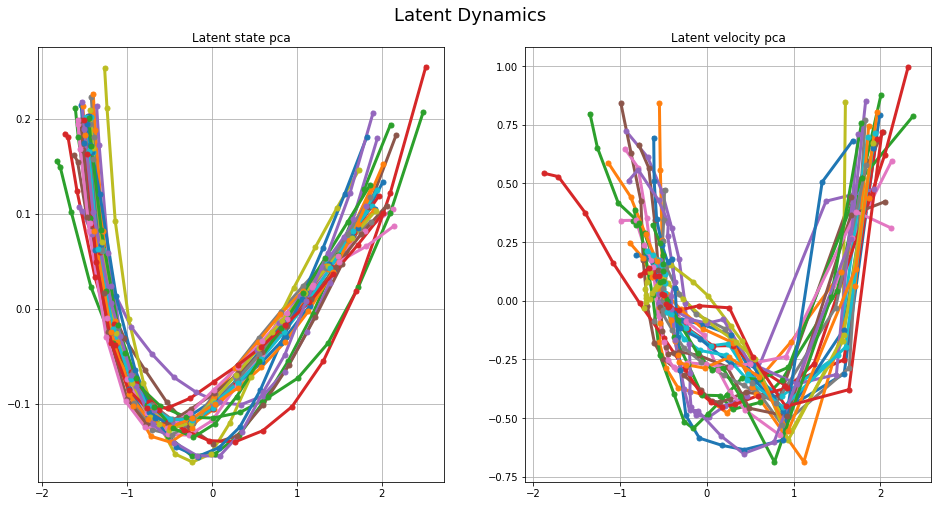

In [33]:
# create subplots
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
fig.suptitle("Latent Dynamics", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        st_pca = pca.fit_transform(st_mu[n]) # T,2
        vt_pca = pca.fit_transform(vt_mu[n])

        ax1.plot(st_pca[:,0], st_pca[:,1],lw=3)
        ax1.scatter(st_pca[:,0], st_pca[:,1], s = 25, zorder=2.5)
        ax1.set_title('Latent state pca')


        ax2.plot(vt_pca[:,0], vt_pca[:,1], lw=3)
        ax2.scatter(vt_pca[:,0], vt_pca[:,1], s = 25, zorder=2.5)
        ax2.set_title('Latent velocity pca')

ax1.grid()
ax2.grid()
plt.show()


In [27]:
st_pca[:,0].shape

(16,)

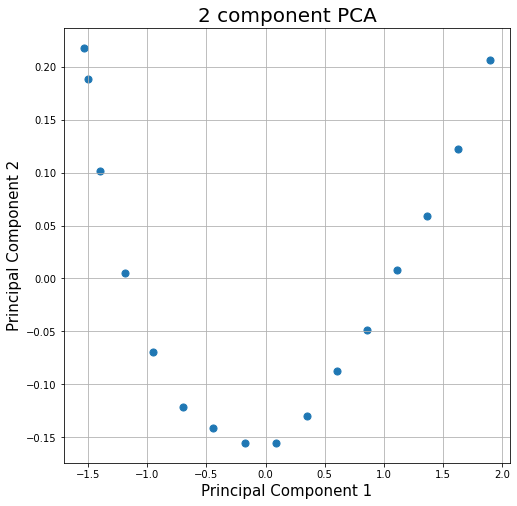

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(st_pca[:,0], st_pca[:,1],s = 50)
ax.grid()
plt.show()

In [34]:
plt.plot(st_pca)
plt.show()

/var/folders/t6/wdrxmnc905n_t_ny9950w_j00000gn/T/ipykernel_72455/3706263016.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
